<a href="https://colab.research.google.com/github/koushik980/NLP/blob/main/NLP_F_31_10_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== TASK 1: HMM-based POS Tagging ===
Training POS tagger on Brown corpus (universal tagset)...
HMM tagger trained successfully.
HMM approx accuracy on brown sample: 0.9577
Folder 'political_articles' not found or insufficient files. Creating 10 synthetic political articles for demo.

Sample tagged sentences (first 10):
SENT: A major candidate promises economic reforms and job creation , while rivals focus on healthcare and education .
TAGGED: [('A', 'DET'), ('major', 'ADJ'), ('candidate', 'NOUN'), ('promises', 'VERB'), ('economic', 'ADJ'), ('reforms', 'NOUN'), ('and', 'CONJ'), ('job', 'NOUN'), ('creation', 'NOUN'), (',', '.'), ('while', 'ADP'), ('rivals', 'DET'), ('focus', 'NOUN'), ('on', 'ADP'), ('healthcare', 'NUM'), ('and', 'CONJ'), ('education', 'NOUN'), ('.', '.')]
-----
SENT: The opposition criticized the new bill , arguing that it undermines democratic institutions and centralizes power in the executive branch .
TAGGED: [('The', 'DET'), ('opposition', 'NOUN'), ('criticized', '

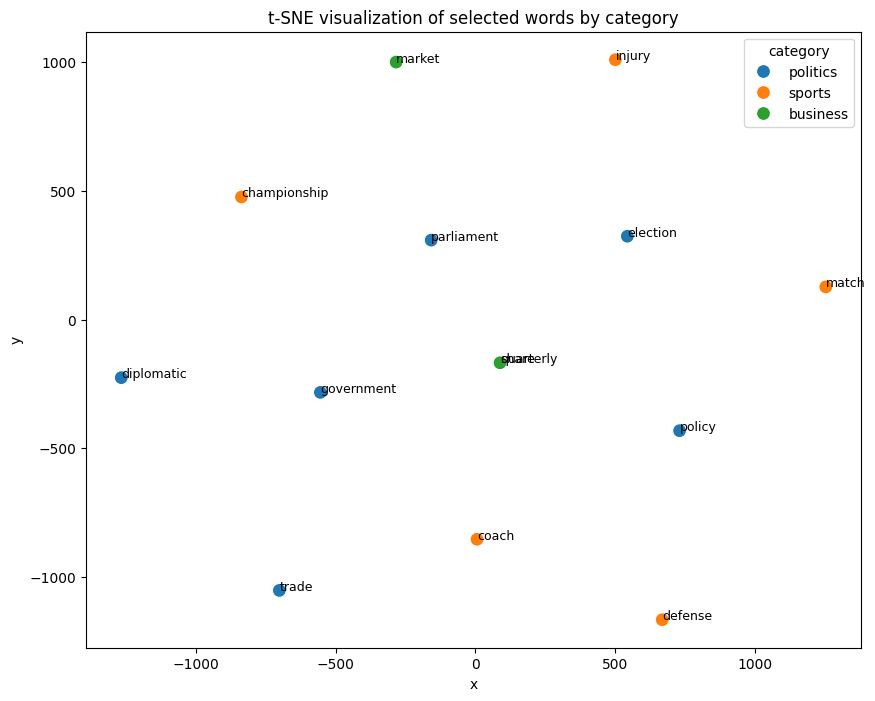

Saved t-SNE plot to tsne_categories.png

=== TASK 3: News classification: Naive Bayes vs CNN (PyTorch) ===

Training Multinomial Naive Bayes baseline...
Naive Bayes classification report:
              precision    recall  f1-score   support

    business       1.00      1.00      1.00        40
    politics       1.00      1.00      1.00        40
      sports       1.00      1.00      1.00        40

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

NB Acc=1.0000, Macro-F1=1.0000

Preparing data and vocab for CNN...
Vocab size: 75
Using device: cpu
Epoch 1: TrainLoss=0.4254, ValAcc=1.0000
Epoch 2: TrainLoss=0.0086, ValAcc=1.0000
Epoch 3: TrainLoss=0.0025, ValAcc=1.0000
Epoch 4: TrainLoss=0.0009, ValAcc=1.0000
Epoch 5: TrainLoss=0.0011, ValAcc=1.0000
Epoch 6: TrainLoss=0.0007, ValAcc=1.0000

CNN classification report:
              precision    recall  f1-score   support

 

In [1]:
import os
import random
import math
import pickle
from pathlib import Path
from collections import Counter, defaultdict

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import brown
from nltk.tag import UnigramTagger, BigramTagger
from nltk.probability import LidstoneProbDist
from nltk.tag import hmm as nltk_hmm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Try to import gensim; if missing we'll fallback
try:
    import gensim
    from gensim.models import Word2Vec
    GENSIM_AVAILABLE = True
except Exception:
    GENSIM_AVAILABLE = False

# download minimal NLTK resources used (brown). We will not rely on punkt-based tokenizers.
nltk.download('brown', quiet=True)
nltk.download('universal_tagset', quiet=True)

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ----------------- Lightweight tokenizers (regex-based) -----------------
_sent_split_re = re.compile(r'(?<=[.!?])\s+')
_word_token_re = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?|[^\sA-Za-z0-9]")

def split_sentences(text):
    """Split text into sentences using a simple regex (avoids NLTK punkt)."""
    if not isinstance(text, str):
        text = str(text)
    text = text.strip()
    if not text:
        return []
    # Split on punctuation followed by whitespace
    sents = _sent_split_re.split(text)
    # further strip and filter empties
    return [s.strip() for s in sents if s.strip()]

def tokenize_words(text):
    """Tokenize words using regex (avoids NLTK word_tokenize dependence)."""
    if not isinstance(text, str):
        text = str(text)
    tokens = _word_token_re.findall(text)
    return tokens

# ----------------------------- Task 1: HMM-based POS Tagging -----------------------------
def train_hmm_tagger():
    """
    Train an HMM POS tagger on the Brown corpus (universal tagset).
    Returns a tagger object with .tag(list_of_tokens) method (or fallback tagger).
    """
    print("Training POS tagger on Brown corpus (universal tagset)...")
    tagged_sents_view = brown.tagged_sents(tagset='universal')
    tagged_sents = list(tagged_sents_view)  # convert to list so we can shuffle
    random.shuffle(tagged_sents)
    split = int(0.9 * len(tagged_sents))
    train_sents = tagged_sents[:split]
    test_sents = tagged_sents[split:]

    try:
        estimator = lambda fd, bins: LidstoneProbDist(fd, 0.1, bins)
        trainer = nltk_hmm.HiddenMarkovModelTrainer()
        hmm_tagger = trainer.train_supervised(train_sents, estimator=estimator)
        print("HMM tagger trained successfully.")
        # quick approximate evaluation on a small held-out sample
        sample_test = test_sents[:200]
        test_tokens = [[w for w,t in s] for s in sample_test]
        gold = [[t for w,t in s] for s in sample_test]
        pred = [[tag for w,tag in hmm_tagger.tag(sent)] for sent in test_tokens]
        correct = 0
        total = 0
        for g,p in zip(gold,pred):
            for a,b in zip(g,p):
                total += 1
                if a == b: correct += 1
        acc = correct / total if total > 0 else 0.0
        print(f"HMM approx accuracy on brown sample: {acc:.4f}")
        return hmm_tagger
    except Exception as e:
        print("HMM training failed or is not available. Falling back to Unigram+Bigram. Error:", e)
        unigram = UnigramTagger(train_sents)
        bigram = BigramTagger(train_sents, backoff=unigram)
        print("Fallback BigramTagger trained.")
        return bigram

# ----------------------------- Helper: political articles -----------------------------
def load_or_create_political_articles(folder="political_articles", n=10):
    folder_p = Path(folder)
    articles = []
    if folder_p.exists() and folder_p.is_dir():
        files = list(folder_p.glob("*.txt"))
        for f in files[:n]:
            articles.append(f.read_text(encoding='utf-8'))
    if len(articles) >= n:
        print(f"Loaded {len(articles)} articles from {folder}")
        return articles[:n]
    print(f"Folder '{folder}' not found or insufficient files. Creating {n} synthetic political articles for demo.")
    templates = [
        "The government announced new policies about the election and public health. Experts said this move will affect voter turnout and campaign strategies.",
        "The opposition criticized the new bill, arguing that it undermines democratic institutions and centralizes power in the executive branch.",
        "International relations are heated after the summit, with trade tariffs discussed and diplomatic channels strained by recent incidents.",
        "A major candidate promises economic reforms and job creation, while rivals focus on healthcare and education.",
        "The parliament voted on the controversial measure, with fierce debates, protests outside, and legal challenges expected.",
    ]
    synthetic = []
    for i in range(n):
        sents = [random.choice(templates) for _ in range(4)]
        synthetic.append(" ".join(sents))
    return synthetic

def tokenize_sentences_and_words(article_text):
    """Return list-of-lists tokens per sentence using regex tokenizers."""
    sents = split_sentences(article_text)
    tokenized = [tokenize_words(s) for s in sents]
    return tokenized

def evaluate_tagger_on_articles(tagger, articles):
    all_tagged = []
    for art in articles:
        toks_sents = tokenize_sentences_and_words(art)
        for sent in toks_sents:
            try:
                tagged = tagger.tag(sent)
            except Exception:
                tagged = [(w, 'NOUN') for w in sent]
            all_tagged.append((sent, tagged))
    return all_tagged

# ----------------------------- Task 2: Embeddings & t-SNE Visualization -----------------------------
def prepare_corpus_for_embedding(all_texts):
    tokenized = []
    for doc in all_texts:
        for sent in split_sentences(doc):
            toks = [w.lower() for w in tokenize_words(sent) if any(c.isalnum() for c in w)]
            if toks:
                tokenized.append(toks)
    return tokenized

def train_word_embeddings(tokenized_sentences, vector_size=100, window=5, min_count=2):
    if GENSIM_AVAILABLE:
        print("Training Word2Vec embeddings with gensim...")
        model = Word2Vec(sentences=tokenized_sentences, vector_size=vector_size,
                         window=window, min_count=min_count, workers=2, seed=RANDOM_SEED)
        wv = model.wv
        word_vectors = {w: wv[w] for w in wv.index_to_key}
        print(f"Trained Word2Vec with vocab size {len(word_vectors)}")
        return word_vectors, 'word2vec'
    else:
        print("gensim not available. Using CountVectorizer + TruncatedSVD as fallback embeddings...")
        docs = [" ".join(s) for s in tokenized_sentences]
        vectorizer = CountVectorizer(min_df=2)
        X = vectorizer.fit_transform(docs)
        svd = TruncatedSVD(n_components=vector_size, random_state=RANDOM_SEED)
        svd.fit(X)
        comp = svd.components_.T
        vocab = vectorizer.get_feature_names_out()
        word_vectors = {w: comp[i] for i, w in enumerate(vocab)}
        print(f"Fallback embeddings for {len(word_vectors)} words.")
        return word_vectors, 'svd'

def tsne_visualize_words(word_vectors, category_word_lists, out_png="tsne_words.png"):
    plot_words = []
    labels = []
    for cat, words in category_word_lists.items():
        for w in words:
            if w in word_vectors:
                plot_words.append(w)
                labels.append(cat)
            elif w.lower() in word_vectors:
                plot_words.append(w.lower())
                labels.append(cat)
    if not plot_words:
        print("No words from category lists found in embeddings. Skipping t-SNE.")
        return
    vectors = np.vstack([word_vectors[w] for w in plot_words])
    tsne = TSNE(n_components=2, perplexity=8, learning_rate=200, random_state=RANDOM_SEED, init='pca')
    X2 = tsne.fit_transform(vectors)
    df = pd.DataFrame({'x': X2[:,0], 'y': X2[:,1], 'word': plot_words, 'category': labels})
    plt.figure(figsize=(10,8))
    sns.scatterplot(data=df, x='x', y='y', hue='category', s=100)
    for i,row in df.iterrows():
        plt.text(row.x+0.5, row.y+0.5, row.word, fontsize=9)
    plt.title("t-SNE visualization of selected words by category")
    plt.savefig(out_png, bbox_inches='tight', dpi=200)
    plt.show()
    print(f"Saved t-SNE plot to {out_png}")

# ----------------------------- Task 3: News Classification Baseline (NB) and CNN (PyTorch) -----------------------------
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab=None, max_len=200):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        if vocab is None:
            vect = CountVectorizer(min_df=1)
            vect.fit(texts)
            self.vocab = {w:i+1 for i,w in enumerate(vect.get_feature_names_out())}
        else:
            self.vocab = vocab
        self.unk_idx = len(self.vocab) + 1

    def text_to_indices(self, text):
        toks = [w.lower() for w in tokenize_words(text) if any(c.isalnum() for c in w)]
        idxs = [self.vocab.get(w, self.unk_idx) for w in toks]
        if len(idxs) >= self.max_len:
            return idxs[:self.max_len]
        else:
            return idxs + [0] * (self.max_len - len(idxs))

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = np.array(self.text_to_indices(self.texts[idx]), dtype=np.int64)
        y = np.int64(self.labels[idx])
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, num_classes=3, kernel_sizes=[3,4,5], num_filters=100, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size+2, embedding_dim=embed_dim, padding_idx=padding_idx)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k) for k in kernel_sizes])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        emb = emb.permute(0,2,1)
        conv_outs = [torch.relu(conv(emb)) for conv in self.convs]
        pooled = [torch.max(co, dim=2)[0] for co in conv_outs]
        cat = torch.cat(pooled, dim=1)
        out = self.dropout(cat)
        logits = self.fc(out)
        return logits

def train_cnn(model, train_loader, val_loader, epochs=6, lr=1e-3, device='cpu'):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    best_val = 0.0
    best_state = None
    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for xb,yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = crit(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        avg_train_loss = total_loss / len(train_loader.dataset)
        model.eval()
        preds = []
        trues = []
        with torch.no_grad():
            for xb,yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                ps = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(ps.tolist())
                trues.extend(yb.cpu().numpy().tolist())
        acc = accuracy_score(trues, preds)
        if acc > best_val:
            best_val = acc
            best_state = model.state_dict()
        print(f"Epoch {ep}: TrainLoss={avg_train_loss:.4f}, ValAcc={acc:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def evaluate_model_model_on_texts(model, dataset, device='cpu', batch_size=64):
    loader = DataLoader(dataset, batch_size=batch_size)
    model.to(device)
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb,yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            ps = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(ps.tolist())
            trues.extend(yb.numpy().tolist())
    return trues, preds

# ----------------------------- Demo data for classification (3-class) -----------------------------
def load_or_create_classification_dataset():
    path = Path("news_dataset.csv")
    if path.exists():
        df = pd.read_csv(path)
        if not {'text','label'}.issubset(df.columns):
            raise ValueError("news_dataset.csv must contain 'text' and 'label' columns")
        return df['text'].tolist(), df['label'].tolist()
    print("Creating synthetic news dataset for demonstration (politics, sports, business).")
    politics = [
        "The government passed a new bill that affects election reform and public spending.",
        "Opposition leaders criticized the policy and called for new oversight committees.",
        "Diplomatic talks focused on trade agreements and national security cooperation.",
    ]
    sports = [
        "The team won the championship after a thrilling match in overtime.",
        "The coach praised the players' defense and tactical discipline.",
        "Injury time changed the outcome of the game and fans celebrated the victory.",
    ]
    business = [
        "The company reported record profits after launching their new product line.",
        "Investors reacted to the quarterly results by adjusting share prices.",
        "Mergers and acquisitions in the sector drove market consolidation.",
    ]
    texts = []
    labels = []
    for _ in range(200):
        texts.append(" ".join(random.choices(politics, k=3)))
        labels.append("politics")
        texts.append(" ".join(random.choices(sports, k=3)))
        labels.append("sports")
        texts.append(" ".join(random.choices(business, k=3)))
        labels.append("business")
    return texts, labels

# ----------------------------- MAIN RUN -----------------------------
def main():
    print("\n=== TASK 1: HMM-based POS Tagging ===")
    tagger = train_hmm_tagger()
    articles = load_or_create_political_articles(n=10)
    tagged_examples = evaluate_tagger_on_articles(tagger, articles)
    print("\nSample tagged sentences (first 10):")
    for sent, tagged in tagged_examples[:10]:
        print("SENT:", " ".join(sent))
        print("TAGGED:", tagged)
        print("-----")

    surprising = []
    for sent, tagged in tagged_examples:
        for w,t in tagged:
            if t == '.' or t == ',':
                surprising.append((sent, tagged))
                break
        if len(surprising) >= 5:
            break
    if surprising:
        print("\nExamples potentially problematic (heuristic detection):")
        for sent, tagged in surprising[:5]:
            print("SENT:", " ".join(sent))
            print("TAGGED:", tagged)
            print("-----")

    print("\n=== TASK 2: Embedding training and visualization ===")
    cls_texts, cls_labels = load_or_create_classification_dataset()
    corpus_texts = cls_texts + articles
    tokenized_sentences = prepare_corpus_for_embedding(corpus_texts)
    word_vectors, method = train_word_embeddings(tokenized_sentences, vector_size=100)
    print("Embedding method used:", method)

    politics_words = ["election", "government", "policy", "vote", "minister", "parliament", "diplomatic", "trade"]
    sports_words = ["championship", "coach", "match", "score", "goal", "defense", "injury", "league"]
    business_words = ["profit", "investor", "market", "merger", "share", "acquisition", "quarterly", "revenue"]

    cat_words = {
        'politics': politics_words,
        'sports': sports_words,
        'business': business_words
    }
    tsne_visualize_words(word_vectors, cat_words, out_png="tsne_categories.png")

    print("\n=== TASK 3: News classification: Naive Bayes vs CNN (PyTorch) ===")
    texts, labels = cls_texts, cls_labels
    le = LabelEncoder()
    y = le.fit_transform(labels)
    X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

    print("\nTraining Multinomial Naive Bayes baseline...")
    tfv = TfidfVectorizer(min_df=2, ngram_range=(1,2))
    Xtr_tfidf = tfv.fit_transform(X_train)
    Xte_tfidf = tfv.transform(X_test)
    nb = MultinomialNB()
    nb.fit(Xtr_tfidf, y_train)
    nb_preds = nb.predict(Xte_tfidf)
    print("Naive Bayes classification report:")
    print(classification_report(y_test, nb_preds, target_names=le.classes_))
    nb_acc = accuracy_score(y_test, nb_preds)
    nb_f1 = f1_score(y_test, nb_preds, average='macro')
    print(f"NB Acc={nb_acc:.4f}, Macro-F1={nb_f1:.4f}")

    print("\nPreparing data and vocab for CNN...")
    train_dataset = NewsDataset(X_train, y_train, vocab=None, max_len=200)
    test_dataset = NewsDataset(X_test, y_test, vocab=train_dataset.vocab, max_len=200)
    vocab_size = len(train_dataset.vocab) + 2
    print("Vocab size:", len(train_dataset.vocab))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=128)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", device)
    cnn_model = CNNTextClassifier(vocab_size=vocab_size, embed_dim=100, num_classes=len(le.classes_))
    cnn_model = train_cnn(cnn_model, train_loader, val_loader, epochs=6, lr=1e-3, device=device)

    trues, preds = evaluate_model_model_on_texts(cnn_model, test_dataset, device=device)
    print("\nCNN classification report:")
    print(classification_report(trues, preds, target_names=le.classes_))
    cnn_acc = accuracy_score(trues, preds)
    cnn_f1 = f1_score(trues, preds, average='macro')
    print(f"CNN Acc={cnn_acc:.4f}, Macro-F1={cnn_f1:.4f}")

    print("\n--- Comparison ---")
    print(f"Naive Bayes: Acc={nb_acc:.4f}, Macro-F1={nb_f1:.4f}")
    print(f"CNN (1D):    Acc={cnn_acc:.4f}, Macro-F1={cnn_f1:.4f}")
    if cnn_f1 > nb_f1:
        print("CNN outperformed Naive Bayes on this dataset (likely better at capturing local n-gram structure).")
    else:
        print("Naive Bayes performed comparably or better — on small synthetic/simple datasets NB can be very strong.")

    print("\nSample predictions (CNN):")
    for i in range(10):
        text = X_test[i]
        true_label = le.inverse_transform([y_test[i]])[0]
        idxs = test_dataset.text_to_indices(text)
        xb = torch.tensor([idxs], dtype=torch.long).to(device)
        cnn_model.to(device)
        cnn_model.eval()
        with torch.no_grad():
            logits = cnn_model(xb)
            pred_idx = int(torch.argmax(logits, dim=1).cpu().numpy()[0])
        pred_label = le.inverse_transform([pred_idx])[0]
        print(f"Text (truncated): {text[:120]}...")
        print(f"True: {true_label} | Pred: {pred_label}")
        print("-----")

    print("\nAll tasks completed. Outputs:")
    print(" - t-SNE plot saved as 'tsne_categories.png'")

if __name__ == "__main__":
    main()